<a href="https://colab.research.google.com/gist/qbeer/c7630c11339b659843e32e39eb732e42/hw5_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logistic regression

### 1. Download data from https://science.sciencemag.org/content/359/6378/926 (supplementary materials).

* read the abstract of the article to get familiar with data origin
* open the data in excel and get familiar with its content
* load the protein level data (you need to figure out which one is that) as a pandas dataframe
* handle missing values and convert features to numeric values when it is needed
* get rid of the unnecessary (which does not encode protein levels or the tumor type) columns and the CancerSEEK results

### 2. Predict if a sample is cancerous or not

* your need to build a classifier that predicts the probability of a sample coming from a cancerous (tumor type is normal or not) person based on the measured protein levels
* train a logistic regression (sklearn API) on every second sample (not first 50% of the data (!), use every second line)
* generate prediction for the samples that were not used during the training

###  3. Comparision to CancerSEEK
* plot the ROC curve and calculate the confusion matrix for the predictions
* do the same for the CancerSEEK predictions
* compare your model's performance to CancerSEEK performance

### 4. Hepatocellular carcinoma

* fit a logistic regression (using statsmodels API this time) to predict if a sample has Hepatocellular carcinoma (liver cancer) or not. You need to keep only the liver and the normal samples for this exercise! For fitting use only the first 25 features and all the rows (which are liver or normal)
* select the 5 best predictor based on P values.
* Write down the most important features (based on P value) and compare them to the tumor markers that you find on wikipeida https://en.wikipedia.org/wiki/Hepatocellular_carcinoma or other sources!

### 5. Multiclass classification

* Again, using every second datapoint train a logistic regression (sklearn API) to predict the tumor type. It is a multiclass classification problem.
* Generate prediction for the rest of the dataset and show the confution matrix for the predictions!
* Plot the ROC curves for the different cancer types on the same plot!
* Intepret your results. Which cancer type can be predicted the most reliably?

### Hints:

* On total you can get 10 points for fully completing all tasks.
* Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
* Comments you code when necessary
* Write functions for repetitive tasks!
* Use the pandas package for data loading and handling
* Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
* Use the scikit learn package for almost everything
* Use for loops only if it is really necessary!
* Code sharing is not allowed between student! Sharing code will result in zero points.
* If you use code found on web, it is OK, but, make its source clear!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import statsmodels.discrete.discrete_model as sm

import warnings
warnings.filterwarnings("ignore")

---------------
### 1. Download data from https://science.sciencemag.org/content/359/6378/926 (supplementary materials).

* read the abstract of the article to get familiar with data origin
* open the data in excel and get familiar with its content
* load the protein level data (you need to figure out which one is that) as a pandas dataframe
* handle missing values and convert features to numeric values when it is needed
* get rid of the unnecessary (which does not encode protein levels or the tumor type) columns and the CancerSEEK results
---------------

Abstract
Earlier detection is key to reducing cancer deaths. Here, we describe a blood test that can detect eight common cancer types through assessment of the levels of circulating proteins and mutations in cell-free DNA. We applied this test, called CancerSEEK, to 1005 patients with nonmetastatic, clinically detected cancers of the ovary, liver, stomach, pancreas, esophagus, colorectum, lung, or breast. CancerSEEK tests were positive in a median of 70% of the eight cancer types. The sensitivities ranged from 69 to 98% for the detection of five cancer types (ovary, liver, stomach, pancreas, and esophagus) for which there are no screening tests available for average-risk individuals. The specificity of CancerSEEK was greater than 99%: only 7 of 812 healthy controls scored positive. In addition, CancerSEEK localized the cancer to a small number of anatomic sites in a median of 83% of the patients.

In [2]:
df=pd.read_excel('aar3247_Cohen_SM_Tables-S1-S11.xlsx', 
                 sheet_name='Table S6', 
                 skiprows=2, 
                 skipfooter=4)

df=df.drop_duplicates()

df.pop('Sample ID #')
df.pop('AJCC Stage')
patients = df.pop('Patient ID #')
df.dropna(axis=0, inplace=True)


for i in df.columns.values[1:-2]:
    df[i] = df[i].astype(str).str.replace('*', '').astype(float)

if np.array([pd.api.types.is_numeric_dtype(i) for i in df.dtypes.values[1:-2]]).all():
    print('All the features are in numeric format.')


display(df.head(4))
display(df.tail(4))



All the features are in numeric format.


,Tumor type,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),CD44 (ng/ml),CEA (pg/ml),CYFRA 21-1 (pg/ml),...,sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
0,Colorectum,1583.450,5598.50,3621.04,5.090,19.08,16.452,9.81,540.07,1938.654,...,204.792,55.06,6832.07,9368.53,16.086,21863.74,56428.71,39498.82,0.938342,Positive
1,Colorectum,715.308,20936.35,2772.96,7.270,10.04,40.910,27.57,5902.43,1938.654,...,204.792,72.92,5549.47,6224.55,16.086,29669.66,73940.49,41277.09,0.925363,Positive
2,Colorectum,4365.530,2350.93,4120.77,4.854,16.96,16.452,14.59,973.75,1976.940,...,204.792,173.78,3698.16,4046.48,179.030,6020.47,22797.28,28440.60,0.852367,Negative
3,Colorectum,715.308,1604.34,2029.96,5.390,8.31,16.452,7.78,2027.53,1938.654,...,204.792,29.47,5856.00,6121.93,16.086,4331.02,20441.19,25896.73,0.617639,Negative


,Tumor type,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),CD44 (ng/ml),CEA (pg/ml),CYFRA 21-1 (pg/ml),...,sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
1813,Ovary,1337.330,1607.90,852.37,5.58,9.80,16.44,12.32,1179.51,1970.916,...,207.24,147.17,7951.03,12966.19,16.89,599.40,123443.76,54066.98,0.999995,Positive
1814,Ovary,879.498,1592.84,1044.45,30.48,8.48,16.44,8.26,443.01,3589.730,...,207.24,104.63,2396.36,1901.41,16.89,599.40,104070.89,39844.02,1.000000,Positive
1815,Ovary,879.498,5267.95,1445.69,1469.45,23.74,62.26,16.53,443.01,50659.050,...,207.24,73.55,3079.81,5312.90,16.89,6864.33,110579.24,42921.13,1.000000,Positive
1816,Ovary,879.498,3546.43,1493.32,1428.31,836.85,37.90,13.78,443.01,3060.110,...,207.24,72.22,3967.55,4045.18,16.89,12877.10,88464.04,47219.24,1.000000,Positive


In [3]:
y=df.pop('Tumor type')
SEEK=df.pop('CancerSEEK Logistic Regression Score')
SEEK_class=df.pop('CancerSEEK Test Result')

----------------
### 2. Predict if a sample is cancerous or not

* your need to build a classifier that predicts the probability of a sample coming from a cancerous (tumor type is normal or not) person based on the measured protein levels
* train a logistic regression (sklearn API) on every second sample (not first 50% of the data (!), use every second line)
* generate prediction for the samples that were not used during the training

----------------

In [4]:
y_bin=np.ones_like(y)
y_bin[y=='Normal']=0
y_bin=list(y_bin)
print(np.mean(y_bin))

df=(df-df.mean())/df.std()

0.5568496949528563


In [5]:
logreg=LogisticRegression()
logreg.fit(df.values[::2], y_bin[::2])
pred=logreg.predict_proba(df.values[1::2])

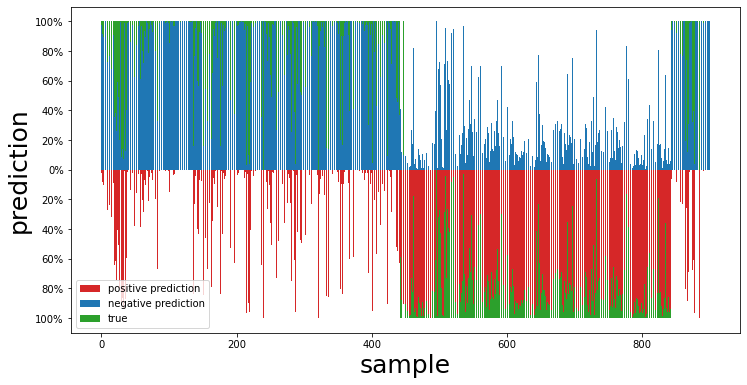

In [6]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
ax.bar(np.arange(len(pred)),-pred[:,0], color='tab:red',label='positive prediction')
ax.bar(np.arange(len(pred)),pred[:,1], color='tab:blue',label='negative prediction')

ax.set_yticks(np.arange(-1,1.01,0.2))
ax.set_yticklabels(str(int(np.round(100*np.abs(i))))+'%' for i in np.arange(-1,1.01,0.2))

ax.bar(np.arange(len(pred)),2*(np.asarray(y_bin[1::2])-0.5), zorder=-1, color='tab:green',label='true')

ax.set_ylabel('prediction', fontsize=25)
ax.set_xlabel('sample',fontsize=25)
ax.legend()
plt.show()

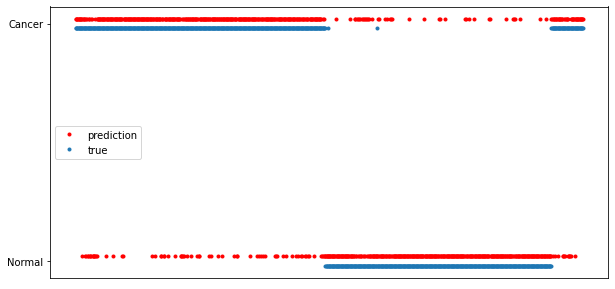

In [7]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

ax.plot(np.arange(len(pred)),np.round(pred[:,1])+0.02,'r.', label='prediction')
ax.plot(np.arange(len(pred)),np.asarray(y_bin[1::2])-0.02,'.', label='true')

ax.set_yticks([0,1])
ax.set_xticks([])
ax.set_yticklabels(['Normal', 'Cancer'])
ax.legend()
plt.show()

----------------
###  3. Comparision to CancerSEEK
* plot the ROC curve and calculate the confusion matrix for the predictions
* do the same for the CancerSEEK predictions
* compare your model's performance to CancerSEEK performance
------------------

In [8]:
print('The confusion matrix: \n \n',confusion_matrix(y_true=y_bin[1::2],y_pred=np.round(pred[:,1])))

The confusion matrix: 
 
 [[357  42]
 [ 85 417]]


In [9]:
print('The confusion matrix for CancerSEEK: \n \n',confusion_matrix(y_true=y_bin[1::2],y_pred=np.round(SEEK[1::2])))

The confusion matrix for CancerSEEK: 
 
 [[356  43]
 [104 398]]


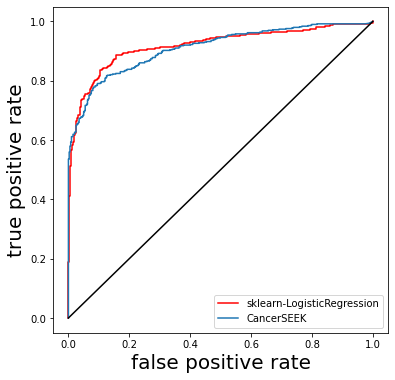

In [10]:
#ROC curve

fig,ax=plt.subplots(1,1,figsize=(6,6))

fpr,tpr,_=roc_curve(y_bin[1::2], pred[:,1])
ax.plot(fpr,tpr,'r-', label='sklearn-LogisticRegression')

fpr,tpr,_=roc_curve(y_bin[1::2], SEEK[1::2])
ax.plot(fpr,tpr,'-', label='CancerSEEK')

ax.plot([0,1],[0,1],'k')

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel('false positive rate', fontsize=20)
ax.set_ylabel('true positive rate', fontsize=20)
ax.legend()
plt.show()

### 4. Hepatocellular carcinoma

* fit a logistic regression (using statsmodels API this time) to predict if a sample has Hepatocellular carcinoma (liver cancer) or not. You need to keep only the liver and the normal samples for this exercise! For fitting use only the first 25 features and all the rows (which are liver or normal)
* select the 5 best predictor based on P values.
* Write down the most important features (based on P value) and compare them to the tumor markers that you find on wikipeida https://en.wikipedia.org/wiki/Hepatocellular_carcinoma or other sources!

In [11]:
df=pd.read_excel('aar3247_Cohen_SM_Tables-S1-S11.xlsx', 
                 sheet_name='Table S6', 
                 skiprows=2, 
                 skipfooter=4)

df=df.drop_duplicates()

df.pop('Sample ID #')
df.pop('AJCC Stage')
patients = df.pop('Patient ID #')
df.dropna(axis=0, inplace=True)


for i in df.columns.values[1:-2]:
    df[i] = df[i].astype(str).str.replace('*', '').astype(float)

y=df.pop('Tumor type')
SEEK=df.pop('CancerSEEK Logistic Regression Score')
SEEK_class=df.pop('CancerSEEK Test Result')

#######################################

data=df.loc[y.isin(['Normal', 'Liver'])]
data=(data-data.mean())/data.std()
data.reset_index(inplace=True, drop=True)

y= y[y.isin(['Normal', 'Liver'])]

y_bin=np.ones_like(y)
y_bin[y=='Normal']=0
y_bin=list(y_bin)
print(np.mean(y_bin))

0.05219454329774614


In [12]:
logit=sm.Logit(y_bin, sm.tools.add_constant(data[data.columns.values[:25]]))
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.030263
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  843
Model:                          Logit   Df Residuals:                      817
Method:                           MLE   Df Model:                           25
Date:                Wed, 13 Oct 2021   Pseudo R-squ.:                  0.8523
Time:                        16:18:10   Log-Likelihood:                -25.512
converged:                       True   LL-Null:                       -172.75
Covariance Type:            nonrobust   LLR p-value:                 7.674e-48
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -7.4597      1.469     -5.077      0.000     -10.340  

In [13]:
result.pvalues

const                      3.842634e-07
AFP (pg/ml)                1.710086e-02
Angiopoietin-2 (pg/ml)     5.982439e-01
AXL (pg/ml)                3.317886e-01
CA-125 (U/ml)              4.698151e-02
CA 15-3 (U/ml)             1.058648e-01
CA19-9 (U/ml)              8.882897e-01
CD44 (ng/ml)               1.002615e-02
CEA (pg/ml)                6.516995e-01
CYFRA 21-1 (pg/ml)         6.583911e-01
DKK1 (ng/ml)               4.883949e-03
Endoglin (pg/ml)           4.661130e-01
FGF2 (pg/ml)               3.678792e-01
Follistatin (pg/ml)        1.324394e-01
Galectin-3 (ng/ml)         8.826508e-01
G-CSF (pg/ml)              7.262538e-01
GDF15 (ng/ml)              3.045185e-01
HE4 (pg/ml)                1.408587e-02
HGF (pg/ml)                1.073090e-03
IL-6 (pg/ml)               8.536407e-01
IL-8 (pg/ml)               3.582393e-01
Kallikrein-6 (pg/ml)       5.903362e-01
Leptin (pg/ml)             2.007037e-01
Mesothelin (ng/ml)         1.217366e-01
Midkine (pg/ml)            3.740462e-01


In [14]:
for j,i in enumerate(result.pvalues.sort_values()[1:6].index):
    print(i, 'P values:', result.pvalues.sort_values()[1:6][j])

HGF (pg/ml) P values: 0.0010730899581908
DKK1 (ng/ml) P values: 0.0048839487859955654
CD44 (ng/ml) P values: 0.010026149502408363
HE4 (pg/ml) P values: 0.014085870417044526
AFP (pg/ml) P values: 0.017100861998425712


According to the wikipedia the alpha-fetoprotein (AFP) and DKK1 is the most important protein markers in the recognition of the HCC.

--------------
### 5. Multiclass classification

* Again, using every second datapoint train a logistic regression (sklearn API) to predict the tumor type. It is a multiclass classification problem.
* Generate prediction for the rest of the dataset and show the confution matrix for the predictions!
* Plot the ROC curves for the different cancer types on the same plot!
* Intepret your results. Which cancer type can be predicted the most reliably?

--------------

In [15]:
df=pd.read_excel('aar3247_Cohen_SM_Tables-S1-S11.xlsx', 
                 sheet_name='Table S6', 
                 skiprows=2, 
                 skipfooter=4)

df=df.drop_duplicates()

df.pop('Sample ID #')
df.pop('AJCC Stage')
patients = df.pop('Patient ID #')
df.dropna(axis=0, inplace=True)


for i in df.columns.values[1:-2]:
    df[i] = df[i].astype(str).str.replace('*', '').astype(float)

y=df.pop('Tumor type')
SEEK=df.pop('CancerSEEK Logistic Regression Score')
SEEK_class=df.pop('CancerSEEK Test Result')

df=(df-df.mean())/df.std()

In [16]:
tumor_types=np.unique(y)
print(tumor_types)
#to numerical
y=[list(tumor_types).index(i) for i in y]

['Breast' 'Colorectum' 'Esophagus' 'Liver' 'Lung' 'Normal' 'Ovary'
 'Pancreas' 'Stomach']


In [17]:
logreg=LogisticRegression()
logreg.fit(df[::2], y[::2])
preds=logreg.predict(df[1::2])
preds_probas=logreg.predict_proba(df[1::2])

In [18]:
cm=confusion_matrix(y_true=y[1::2], y_pred=preds)
cm

array([[ 35,  22,   1,   1,   5,  36,   0,   2,   0],
       [ 15, 112,  10,   1,   8,  37,   2,   1,  11],
       [  1,  10,   1,   1,   1,   4,   0,   0,   1],
       [  2,   3,   3,   9,   3,   0,   0,   1,   3],
       [  8,  21,   0,   0,  13,   6,   0,   1,   0],
       [ 14,  13,   0,   0,   2, 368,   0,   1,   1],
       [  2,   3,   0,   0,   0,   2,  19,   0,   2],
       [  1,   7,   1,   0,   2,  10,   0,  27,   0],
       [  2,  14,   4,   0,   8,   4,   0,   1,   2]], dtype=int64)

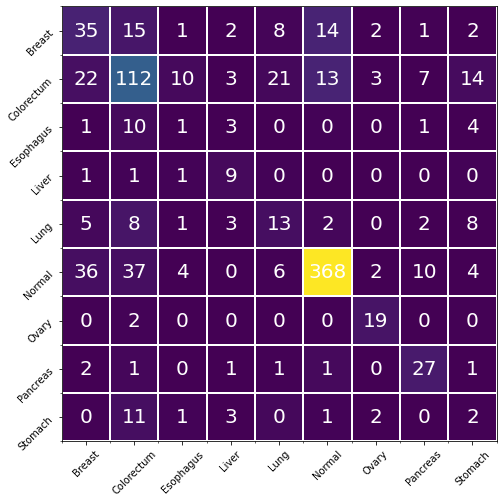

In [19]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.imshow(cm)

ax.set_xticks(np.arange(len(tumor_types)))
ax.set_xticklabels(tumor_types, rotation=45)

ax.set_yticks(np.arange(len(tumor_types)))
ax.set_yticklabels(tumor_types, rotation=45)

ax.set_xticks(np.arange(-.5, len(tumor_types), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(tumor_types),1), minor=True)

ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

for i in np.arange(0,len(tumor_types),1):
    for j in np.arange(0,len(tumor_types),1):
        ax.text(i,j,str(cm[i,j]),ha="center", va="center", color="w", fontsize=20)
plt.show()

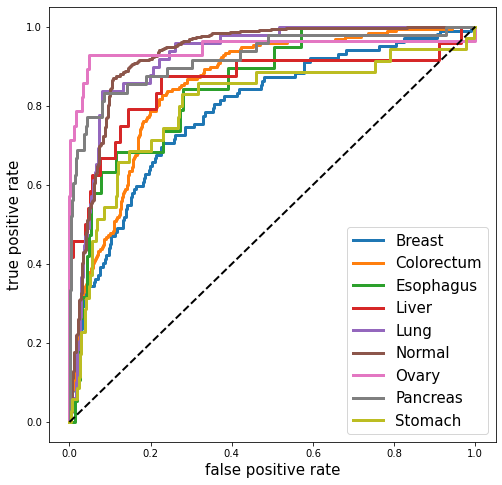

In [20]:
fig,ax=plt.subplots(1,1,figsize=(8, 8))

for i,j in enumerate(tumor_types):
    fpr,tpr,_=roc_curve([int(y_i==i) for y_i in y[1::2]],preds_probas[:,i])

    plt.plot(fpr, tpr, label=j, lw=3)
    
plt.legend(fontsize=15)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate', fontsize=15)

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.show()

It seems like the ovarium prediction is the most reliable and generally, the false positive rate is the most lower in the case of ovarian tumours.